## Housing Price Prediction 
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [4078]:
import pandas as pd
%matplotlib inline
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5015]:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')
rows,columns=train.shape
print('size of trainning data', rows, columns)
print('length of test', len(test))
numeric_features = train.select_dtypes(include=[np.number])
print(numeric_features.columns)
categorical_features = train.select_dtypes(include=[np.object])
print(categorical_features.columns)
#train.head()

size of trainning data 1460 81
length of test 1459
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 

In [5016]:
data=pd.concat([train,test], axis=0,sort=False).reset_index(drop=True) # combine training and test 
data.shape

(2919, 81)

## Fill Missing Data

In [5017]:
nan=pd.isnull(data).sum().sort_values(ascending=False).head(4)
#nan.axes[0].tolist()#ind=(np.where(pd.isnull(data).sum()!=0))#col[ind]

dropcol=[]
for col in nan.axes[0]:
    dropcol.append(col)

In [5018]:
# check too many NaNs or too many features are the same, can not distinguish

for i in data.columns:   # if too many zeros
    if data[i].dtype==np.int64:
        if (data[i]==0).sum() >=2919*0.9:
            print((data[i]==0).sum(),i)
            dropcol.append(i)
for col in data.columns:
    if data[col].dtypes == np.object:
        a=data.groupby(col).count()
        #print(a.Id.max())
        if a.Id.max()>=2919*0.9:  # which means 90% of the information are the same 
            print(a.Id.max(),col)
            dropcol.append(col)

2879 LowQualFinSF
2882 3SsnPorch
2663 ScreenPorch
2906 PoolArea
2816 MiscVal
2907 Street
2916 Utilities
2778 LandSlope
2889 Condition2
2876 RoofMatl
2874 Heating
2723 CentralAir
2671 Electrical
2717 Functional
2654 GarageCond
2641 PavedDrive


In [5019]:
data.drop(columns=dropcol,axis=1,inplace=True)

In [5020]:
pd.isnull(data).sum().sort_values(ascending=False).head(27)

SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
BsmtFullBath       2
Exterior2nd        1
Exterior1st        1
BsmtFinSF1         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFinSF2         1
SaleType           1
GarageArea         1
KitchenQual        1
GarageCars         1
dtype: int64

In [5021]:
categorical_features=data.select_dtypes(include=[np.object])
for c in categorical_features.columns:
    print(c, ':', data[c].unique())

MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH' nan]
LotShape : ['Reg' 'IR1' 'IR2' 'IR3']
LandContour : ['Lvl' 'Bnk' 'Low' 'HLS']
LotConfig : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 : ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
BldgType : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
Exterior1st : ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock' nan]
Exterior2nd : ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbS

In [5082]:
data_loc=data.copy()
data_loc.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Reg,Lvl,Inside,CollgCr,Norm,...,548.0,TA,0,61,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Reg,Lvl,FR2,Veenker,Feedr,...,460.0,TA,298,0,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,IR1,Lvl,Inside,CollgCr,Norm,...,608.0,TA,0,42,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,IR1,Lvl,Corner,Crawfor,Norm,...,642.0,TA,0,35,272,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,IR1,Lvl,FR2,NoRidge,Norm,...,836.0,TA,192,84,0,12,2008,WD,Normal,250000.0


## Feature Engineer

In [5083]:
# Category features
for col in ('GarageFinish','GarageType','BsmtExposure','BsmtQual','BsmtFinType1',\
          'BsmtFinType2','MasVnrType', 'MSZoning','KitchenQual','Exterior1st','Exterior2nd','FireplaceQu',\
           'GarageQual','BsmtCond','SaleType'):
    data_loc[col] = data_loc[col].fillna('None')
# Numeric features        
for col in ('BsmtFullBath','BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF2','BsmtFinSF1','GarageCars',\
           'GarageArea','MasVnrArea','TotalBsmtSF'):
    data_loc[col] = data_loc[col].fillna(0)   

#col=data.columns
data_loc.GarageYrBlt.fillna(2100,inplace=True)
data_loc["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(\
    lambda x: x.fillna(x.median()))


In [5084]:
pd.isnull(data_loc).sum().sort_values(ascending=False).head(5)

SalePrice       1459
BsmtFinType2       0
BsmtFinType1       0
BsmtExposure       0
BsmtCond           0
dtype: int64

In [5085]:
#create new feature      try to include category features into numeric features
data_loc['BsmtBath']=(data_loc.BsmtFullBath+0.5*data_loc.BsmtHalfBath)
data_loc['AbvGr']=data_loc.BedroomAbvGr+data_loc.KitchenAbvGr  
 
data_loc['Age']=(data_loc.YrSold+data_loc.MoSold/12.0)-data_loc.YearBuilt #-
data_loc['Bath']=(data_loc.FullBath+0.5*data_loc.HalfBath)
     
data_loc['Lot']=(data_loc.LotFrontage+data_loc.LotArea) 

codes = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3,'LwQ':2,'Unf':1}
data_loc['BsmtFinType1N'] = data_loc['BsmtFinType1'].map(codes)
data_loc['BsmtFinType1N'].fillna(0,inplace=True)
data_loc['BsmtSF1']=data_loc['BsmtFinType1N']*data_loc['BsmtFinSF1']

codes = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3,'LwQ':2,'Unf':1}
data_loc['BsmtFinType2N'] = data_loc['BsmtFinType2'].map(codes)
data_loc['BsmtFinType2N'].fillna(0,inplace=True)

data_loc['BsmtSF2']=data_loc['BsmtFinType2N']*data_loc['BsmtFinSF2']
#data_loc['SF']=data_loc['BsmtSF2']*data_loc['BsmtSF1']

In [5086]:
data_loc['FlrSF']=data_loc['1stFlrSF']+data_loc['2ndFlrSF']

In [5087]:
train[["MasVnrType", "SalePrice"]].groupby(['MasVnrType'], as_index=False).agg(['mean', 'count'])
#MasVnr
codes = {'Stone':4, 'BrkFace':3, 'None':2, 'BrkCmn':1}
data_loc['MasVnrTypeN'] = data_loc['MasVnrType'].map(codes)

data_loc['MasVnr']=data_loc['MasVnrTypeN']*data_loc['MasVnrArea']

In [5088]:
dropcol2=['YrSold','MoSold','YearBuilt','BsmtFinType1','BsmtFinSF1',\
                    'BsmtFullBath','BsmtHalfBath','BedroomAbvGr',\
                      'KitchenAbvGr','MasVnrType','MasVnrArea','LotFrontage','LotArea','Id',\
           'BsmtFinType1N','MasVnrTypeN','1stFlrSF','2ndFlrSF','BsmtFinType2','BsmtFinSF2',\
          'BsmtFinType2N','FullBath','HalfBath']   

## Drop columns

In [5089]:
data_loc.shape 

(2919, 73)

In [5090]:
#too many NaNs or too much same values e.g., Heating 1428 are using GasA no big difference
data_loc.drop(columns=dropcol2,axis=1,inplace=True)
pd.isnull(data_loc).sum().sort_values(ascending=False).head()

SalePrice       1459
MasVnr             0
YearRemodAdd       0
BsmtUnfSF          0
BsmtExposure       0
dtype: int64

In [5091]:
def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())

#for f in data_loc.select_dtypes(include=[np.number]).columns:
#    data_loc[f]=scale_minmax(data_loc[f])
data_loc.head()

,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,SalePrice,BsmtBath,AbvGr,Age,Bath,Lot,BsmtSF1,BsmtSF2,FlrSF,MasVnr
0,60,RL,Reg,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,...,208500.0,1.0,4,5.166667,2.5,8515.0,4236.0,0.0,1710,588.0
1,20,RL,Reg,Lvl,FR2,Veenker,Feedr,1Fam,1Story,6,...,181500.0,0.5,4,31.416667,2.0,9680.0,4890.0,0.0,1262,0.0
2,60,RL,IR1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,...,223500.0,1.0,4,7.750000,2.5,11318.0,2916.0,0.0,1786,486.0
3,70,RL,IR1,Lvl,Corner,Crawfor,Norm,1Fam,2Story,7,...,140000.0,1.0,4,91.166667,1.0,9610.0,1080.0,0.0,1717,0.0
4,60,RL,IR1,Lvl,FR2,NoRidge,Norm,1Fam,2Story,8,...,250000.0,1.0,5,9.000000,2.5,14344.0,3930.0,0.0,2198,1050.0


In [5092]:
train_loc=data_loc[:len(train)]
#train['TotalBsmtSF'].min()

## Distribution of SalePrice

/Users/hanzhang/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


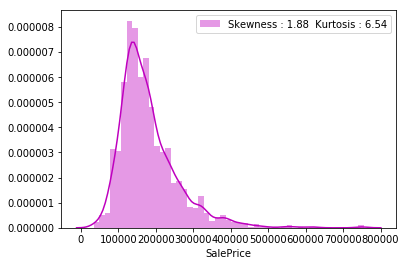

In [5033]:
g = sb.distplot((train_loc["SalePrice"]), color="m", label="Skewness : %.2f  Kurtosis : %.2f"\
                %((train_loc["SalePrice"]).skew(), (train_loc["SalePrice"]).kurt() ))
g = g.legend(loc="best")


In [5034]:
#train_loc["SalePrice"]=train_loc["SalePrice"].map(lambda i: np.log10(i) if i > 0 else 0)

#train_loc["SalePrice"]=train_loc["SalePrice"].map(lambda i: np.log(i) if i > 0 else 0)
#from sklearn import preprocessing

#train_loc["SalePriceN"] = (train_loc["SalePrice"])/train_loc["SalePrice"].max()

#g = sb.distplot((train_loc["SalePrice"]), color="m", label="Skewness : %.2f  Kurtosis : %.2f"\
#                %((train_loc["SalePrice"]).skew(), (train_loc["SalePrice"]).kurt() ))
#g = g.legend(loc="best")

## Check the correlation of the numeric features


In [5093]:
#data_loc2=data_loc.drop(['SalePrice'], axis=1, inplace=True)
data_loc.select_dtypes(include=[np.number]).columns

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'BsmtUnfSF',
       'TotalBsmtSF', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'SalePrice', 'BsmtBath', 'AbvGr', 'Age', 'Bath', 'Lot',
       'BsmtSF1', 'BsmtSF2', 'FlrSF', 'MasVnr'],
      dtype='object')

In [5094]:
#train_loc.loc[train_loc.GrLivArea > 4000] 
# drop two out liars
#train_loc=data_loc[:len(train)]

train_loc.drop(train.index[[523,1298]], inplace=True,axis=0)
data_loc.drop(data.index[[523,1298]], inplace=True,axis=0)
#ax[0,1].scatter(train_loc['GrLivArea'], train_loc['SalePrice'])
#plt.ylabel('SalePrice', fontsize=13)
#plt.xlabel('GrLivArea', fontsize=13)

train_loc.shape

(1458, 50)

In [5095]:
data_loc=data_loc.reset_index(drop=True)
train_loc=train_loc.reset_index(drop=True)


In [5096]:
data_cat = data_loc.select_dtypes(include=[np.object])

In [5097]:
# correlation between numeric features 
corrmat = train_loc.corr()
#f, ax = plt.subplots(figsize=(20, 20))
#a=sb.heatmap(corrmat,annot=True)
#fig = a.get_figure()
#fig.savefig("corr.png")

# ranking 
a=corrmat.abs().sort_values('SalePrice', ascending=False).SalePrice[:]
a

SalePrice        1.000000
OverallQual      0.795774
FlrSF            0.744063
GrLivArea        0.734968
TotalBsmtSF      0.651153
GarageCars       0.641047
GarageArea       0.629217
Bath             0.599932
TotRmsAbvGrd     0.537769
Age              0.523785
MasVnr           0.509898
YearRemodAdd     0.507717
BsmtSF1          0.485844
Fireplaces       0.469862
WoodDeckSF       0.324758
OpenPorchSF      0.321142
Lot              0.268795
BsmtBath         0.226254
BsmtUnfSF        0.214460
EnclosedPorch    0.128646
GarageYrBlt      0.127861
AbvGr            0.121067
MSSubClass       0.084276
OverallCond      0.077948
BsmtSF2          0.005269
Name: SalePrice, dtype: float64

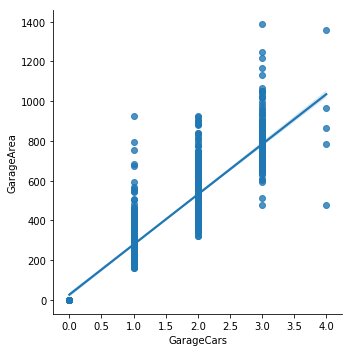

In [5040]:
g=sb.lmplot(x='GarageCars', y='GarageArea', truncate=True, data=train_loc, size=5)

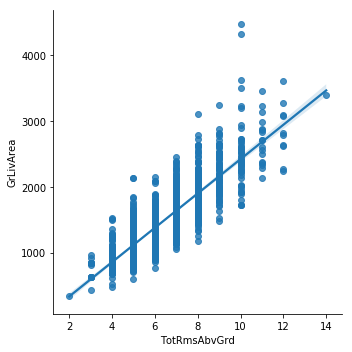

In [5041]:
g=sb.lmplot(x='TotRmsAbvGrd', y='GrLivArea', truncate=True, data=train_loc, size=5)

In [5042]:
#g=sb.lmplot(x='1stFlrSF', y='TotalBsmtSF', truncate=True, data=train_loc, size=5)

In [5098]:
#a=train_loc.select_dtypes(include=[np.number]).columns
a.axes[0]

Index(['SalePrice', 'OverallQual', 'FlrSF', 'GrLivArea', 'TotalBsmtSF',
       'GarageCars', 'GarageArea', 'Bath', 'TotRmsAbvGrd', 'Age', 'MasVnr',
       'YearRemodAdd', 'BsmtSF1', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF',
       'Lot', 'BsmtBath', 'BsmtUnfSF', 'EnclosedPorch', 'GarageYrBlt', 'AbvGr',
       'MSSubClass', 'OverallCond', 'BsmtSF2'],
      dtype='object')

In [5099]:
# select_features with correlation greater than 0.3
select_features=[]
for col in a.axes[0]:
    select_features.append(col)

select_features.remove('MSSubClass')

In [5100]:
def recat_feature(df,cols):
    if df[cols] == 0:
        return 0
    else:
        return 1

In [5101]:
#for f in select_features:
#    print(f,data_loc[f].skew(), data_loc[f].kurt())

In [5047]:
#f, ax = plt.subplots(figsize=(20, 20))
#a=sb.heatmap(data_loc[select_features].corr(),annot=True)
#fig = a.get_figure()
#fig.savefig("corr.png")

From the correlation map, some features are correlated, e.g., TotRmsAbvGrd & GrLiveArea, GarageArea & GarageCars

In [5048]:
train_loc=data_loc[:len(train)-2]

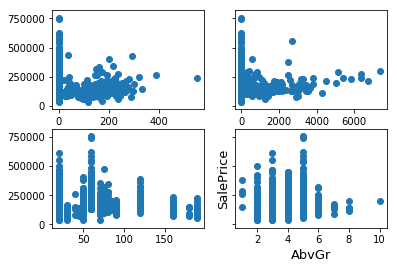

In [5049]:
# check sereral parameters 
fig, ax = plt.subplots(2,2,sharey=True)
ax[0,0].scatter(train_loc['EnclosedPorch'], train_loc['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('EnclosedPorch', fontsize=13)

ax[0,1].scatter(train_loc['BsmtSF2'], train_loc['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('BsmtSF2', fontsize=13)

ax[1,0].scatter(train_loc['MSSubClass'], train_loc['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('MSSubClass', fontsize=13)

ax[1,1].scatter(data_loc['AbvGr'], data_loc['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('AbvGr', fontsize=13)
plt.show()

In [5050]:
#df_out,ind=remove_outlier(train_loc,'SalePrice')
#(np.where(ind == False))
#sb.pairplot(data[select_features], size = 2,kind ='scatter',diag_kind='kde')
#pd.isnull(data_loc[select_features]).sum()

#final.head()

## Category Features

In [5102]:
data_cat.columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [5103]:
for c in data_cat.columns:
    print(c, ':', data_cat[c].unique())

MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH' 'None']
LotShape : ['Reg' 'IR1' 'IR2' 'IR3']
LandContour : ['Lvl' 'Bnk' 'Low' 'HLS']
LotConfig : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 : ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
BldgType : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
Exterior1st : ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock' 'None']
Exterior2nd : ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco'

In [5104]:
#pd.isnull(data_loc).sum().sort_values(ascending=False).head(12)
pd.options.mode.chained_assignment = None

data_loc[['BsmtCond', "SalePrice"]].groupby(['BsmtCond']).agg(['mean', 'count'])

SalePrice      
                   mean count
BsmtCond                     
Fa        121809.533333    45
Gd        213599.907692    65
None      105652.891892    37
Po         64000.000000     2
TA        183649.821238  1309

In [5105]:
data_cat.Exterior2nd[data_cat.Exterior2nd == 'Other']
data_cat.Exterior2nd[595]='Wother'

In [5106]:
#encodeing 
from sklearn.preprocessing import LabelEncoder
num = LabelEncoder()
data_cat['Exterior1stN']=num.fit_transform(data_cat['Exterior1st'].astype('str'))
data_cat['Exterior2ndN']=num.fit_transform(data_cat['Exterior2nd'].astype('str'))

In [5107]:
#data_loc['SaleTypeN']=num.fit_transform(data_loc['SaleType'].astype('str'))
#data_loc['SaleConditionN']=num.fit_transform(data_loc['SaleCondition'].astype('str'))

In [5108]:
codes = {'Gd':4,'TA':3,'Ex':5,'Fa':2,'Po':1,'None':0}
data_cat['ExterQualN'] =data_cat['ExterQual'].map(codes)
data_cat['ExterCondN'] =data_cat['ExterCond'].map(codes)
data_cat['HeatingQCN'] =data_cat['HeatingQC'].map(codes)
data_cat['FireplaceQuN'] =data_cat['FireplaceQu'].map(codes)
data_cat['KitchenQualN'] =data_cat['KitchenQual'].map(codes)

#train_loc[['BsmtQual', "SalePrice"]].groupby(['BsmtQual']).agg(['mean', 'count'])
codes = {'Ex':5,'Gd':4, 'TA':3, 'Fa':2,'Po':1,'None':0}
data_cat['BsmtQualN'] = data_cat['BsmtQual'].map(codes)
data_cat['BsmtCondN'] = data_cat['BsmtCond'].map(codes)

codes = {'Ex':5,'Gd':4, 'TA':3, 'Fa':2,'Po':1,'None':0}
data_cat['GarageQualN'] = data_cat['GarageQual'].map(codes)

codes = {'Gd':4, 'Av':3, 'Mn':2, 'No':1,'None':0}
data_cat['BsmtExposureN'] = data_cat['BsmtExposure'].map(codes)

codes = {'Fin':3,'RFn':2,'Unf':1,'None':0}
data_cat['GarageFinishN'] = data_cat['GarageFinish'].map(codes)


In [5109]:
#Neighborhood
codes={'Veenker':3, 'Crawfor':3, 'NoRidge':3, 'NridgHt':3,\
       'Gilbert':2, 'ClearCr':3,'CollgCr':2,'Somerst':3,'NAmes':2,'SawyerW':2,\
        'StoneBr':3, 'NPkVill':2,'Mitchel':2, 'NWAmes':2,\
       'Timber':3, 'Blmngtn':2,'SWISU':2, 'Blueste':1,'BrDale':1,'BrkSide':1,'Edwards':1,\
       'IDOTRR':1,'MeadowV':1,'OldTown':1, 'Sawyer':1}
data_cat['NeighborhoodN'] = data_cat['Neighborhood'].map(codes)

#MSzoning
codes={'RL':3, 'RM':2, 'C (all)':1, 'FV':4, 'RH':2,'None':0}
data_cat['MSZoningN'] = data_cat['MSZoning'].map(codes)

#HouseStyle
codes={'2Story':3, '1Story':2, '1.5Fin':1, '1.5Unf':1, 'SFoyer':1, 'SLvl':2, '2.5Unf':1,
       '2.5Fin':3}
data_cat['HouseStyleN'] = data_cat['HouseStyle'].map(codes)

codes={'PConc':2, 'CBlock':1, 'BrkTil':1, 'Wood':1.5, 'Slab':1, 'Stone':2}
data_cat['FoundationN'] = data_cat['Foundation'].map(codes)

In [5110]:
train_loc[["SaleCondition", "SalePrice"]].groupby(['SaleCondition'], as_index=False).mean().\
sort_values(by='SalePrice', ascending=False)

codes={'Partial':5, 'Normal':4, 'Alloca':3, 'Family':2, 'Abnorml':1, 'AdjLand':0}
data_cat['SaleConditionN'] = data_cat['SaleCondition'].map(codes)

train_loc[["SaleType", "SalePrice"]].groupby(['SaleType'], as_index=False).mean().\
sort_values(by='SalePrice', ascending=False)

codes={'New':8, 'Con':7, 'CWD':6, 'ConLI':5, 'WD':4, 'COD':3,'ConLw':2,'ConLD':1,'Oth':0,'None':0}
data_cat['SaleTypeN'] = data_cat['SaleType'].map(codes)

#data_cat[["SaleType", "SalePrice"]].groupby(['SaleType'], as_index=False).mean().\
#sort_values(by='SalePrice', ascending=False)

In [5111]:
data_cat.select_dtypes(include=[np.int]).columns

Index(['Exterior1stN', 'Exterior2ndN', 'ExterQualN', 'ExterCondN',
       'HeatingQCN', 'FireplaceQuN', 'KitchenQualN', 'BsmtQualN', 'BsmtCondN',
       'GarageQualN', 'BsmtExposureN', 'GarageFinishN', 'NeighborhoodN',
       'MSZoningN', 'HouseStyleN', 'SaleConditionN', 'SaleTypeN'],
      dtype='object')

In [5112]:
grade_cols=['ExterQualN','KitchenQualN','BsmtQualN','BsmtExposureN',\
            'FireplaceQuN','HeatingQCN','GarageFinishN','HouseStyleN','MSZoningN','NeighborhoodN',\
            'SaleTypeN','SaleConditionN','GarageQualN']

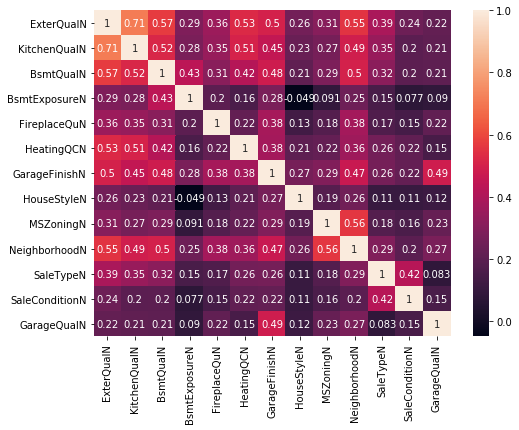

In [5113]:
f, ax = plt.subplots(figsize=(8, 6))
a=sb.heatmap(data_cat[grade_cols].corr(),annot=True)

In [5114]:
pd.isnull(data_cat[grade_cols]).sum()

ExterQualN        0
KitchenQualN      0
BsmtQualN         0
BsmtExposureN     0
FireplaceQuN      0
HeatingQCN        0
GarageFinishN     0
HouseStyleN       0
MSZoningN         0
NeighborhoodN     0
SaleTypeN         0
SaleConditionN    0
GarageQualN       0
dtype: int64

In [5115]:
#train_loc[["GarageFinish", "SalePrice"]].groupby(['GarageFinish']).agg(['mean', 'count'])
#train[["Exterior1st", "SalePrice"]].groupby(['Exterior1st']).agg(['mean', 'count'])

In [5116]:
#train_loc[["SaleCondition", "SalePrice"]].groupby(['SaleCondition'], as_index=False).mean().\
#sort_values(by='SalePrice', ascending=False)
#train_loc[["SaleCondition", "ExterQualN"]].groupby(['SaleCondition']).agg(['mean', 'count'])
#sb.boxplot(x="SaleCondition", y="SalePrice", data=train_loc, palette="PRGn")
#for dummy 

cat=[ 'LotShape', 'LotConfig', 
       'RoofStyle',  'GarageType']

#data_cat=pd.get_dummies(data_loc[cat],drop_first=True)
#data_cat.tail()
#data_cat.shape

In [5117]:
#data_cat[grade_cols] data_loc[select_features],

In [5124]:
data_final=pd.concat([data_loc[select_features],data_cat[grade_cols]], axis=1,sort=False).reset_index(drop=True)
#data_final=numeric_features.drop('SalePrice',axis=1,inplace=True)data_loc[select_features]
data_final.drop(['SalePrice'],axis=1,inplace=True)

In [5125]:
data_final.tail()
pd.isnull(data_final).sum()

OverallQual       0
FlrSF             0
GrLivArea         0
TotalBsmtSF       0
GarageCars        0
GarageArea        0
Bath              0
TotRmsAbvGrd      0
Age               0
MasVnr            0
YearRemodAdd      0
BsmtSF1           0
Fireplaces        0
WoodDeckSF        0
OpenPorchSF       0
Lot               0
BsmtBath          0
BsmtUnfSF         0
EnclosedPorch     0
GarageYrBlt       0
AbvGr             0
OverallCond       0
BsmtSF2           0
ExterQualN        0
KitchenQualN      0
BsmtQualN         0
BsmtExposureN     0
FireplaceQuN      0
HeatingQCN        0
GarageFinishN     0
HouseStyleN       0
MSZoningN         0
NeighborhoodN     0
SaleTypeN         0
SaleConditionN    0
GarageQualN       0
dtype: int64

In [5126]:
X_train = data_final[:len(train_loc)]
Xtest  = data_final[len(train_loc):]
Y_train = train_loc['SalePrice']

In [5127]:
Xtest.shape

(1459, 36)

In [5128]:
#g = sb.distplot(Y_train, color="m", label="Skewness : %.2f  Kurtosis : %.2f"\
#                %((Y_train).skew(), (Y_train).kurt()))
#g = g.legend(loc="best")

## Models

Random Forest; Linear Regression; SVR; xgboost

In [5129]:
# random forest 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# split data into training and validation data, for both predictors and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X_train, Y_train,test_size=0.3)


# Define model
hz_model = RandomForestRegressor(n_estimators=200,random_state = 10)

# Fit model
hz_model.fit(train_X, train_y)

predicted_home_prices = hz_model.predict(val_X)

Y_pred = hz_model.predict(Xtest)
print(mean_absolute_error((val_y), (predicted_home_prices)))


16755.52549086758


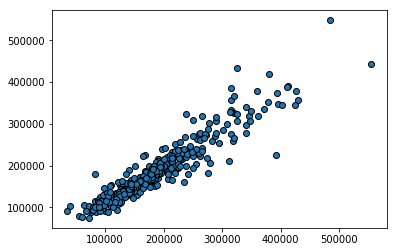

In [5130]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter((val_y), (predicted_home_prices), edgecolors=(0, 0, 0))
#ax.scatter((val_y), (predicted_home_prices), edgecolors=(0, 0, 0))
plt.show()

In [4481]:
hz_model = RandomForestRegressor(n_estimators=200,random_state = 10)
# Fit model
hz_model.fit(X_train, Y_train)

Y_pred = hz_model.predict(Xtest)

In [5131]:
feature_list = list(X_train.columns)

importances = list(hz_model.feature_importances_)
importances
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: OverallQual          Importance: 0.5821144695470651
Variable: FlrSF                Importance: 0.10562099052384041
Variable: GrLivArea            Importance: 0.045037645274667894
Variable: BsmtSF1              Importance: 0.04066205485332257
Variable: TotalBsmtSF          Importance: 0.039356200826797874
Variable: Bath                 Importance: 0.02979804612346101
Variable: Lot                  Importance: 0.02144187915218758
Variable: GarageArea           Importance: 0.019790002982793712
Variable: NeighborhoodN        Importance: 0.01191737881552209
Variable: Age                  Importance: 0.009477922847983149
Variable: MasVnr               Importance: 0.009393774191541578
Variable: KitchenQualN         Importance: 0.008206188718880854
Variable: YearRemodAdd         Importance: 0.00627688756424684
Variable: BsmtQualN            Importance: 0.006150427127096006
Variable: GarageFinishN        Importance: 0.006069654994648866
Variable: BsmtUnfSF            Importance: 0.005

In [5132]:
#xgboost model 
import xgboost

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,\
                           colsample_bytree=1, max_depth=7)
train_X, val_X, train_y, val_y = train_test_split(X_train,Y_train,random_state = 0,test_size=0.3)
hz_model=xgb.fit(train_X,train_y)
Y_pred = hz_model.predict(val_X)
print(mean_absolute_error((val_y),(Y_pred)))

#Y_pred = hz_model.predict(Xtest)

15124.531544306506


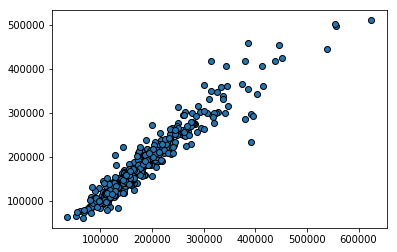

In [5133]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#ax.scatter(np.e**(val_y), np.e**(Y_pred), edgecolors=(0, 0, 0))
ax.scatter((val_y), (Y_pred), edgecolors=(0, 0, 0))
plt.show()

In [5136]:
xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,\
                           colsample_bytree=1, max_depth=7)
hz_model=xgb.fit(X_train,Y_train)
Y_pred = hz_model.predict(Xtest)

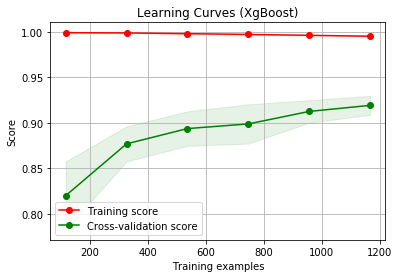

In [5135]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=10, train_sizes=np.linspace(.1, 1.0, 6)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = X_train, Y_train

title = "Learning Curves (RF)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = linear_model.LinearRegression()
estimator = RandomForestRegressor(n_estimators = 200, random_state = 10)
#plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=10)


#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = linear_model.LinearRegression()
#estimator = RandomForestRegressor(n_estimators = 100, random_state = 42)
#plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=10)

title = "Learning Curves (XgBoost)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0.0, subsample=0.75,\
                           colsample_bytree=1, max_depth=7)
#estimator = RandomForestRegressor(n_estimators = 200, random_state = 10)
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=10)

#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = svm.LinearSVR()
#estimator = RandomForestRegressor(n_estimators = 100, random_state = 42)
#plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=10)

plt.show()

In [5137]:
#cols=['Id','SalePrice']
name=test.Id
df=pd.DataFrame(
    {'Id': name,
     'SalePrice': (Y_pred)
    })

print(len(df['Id']))
df.to_csv('submission.csv', index=False)

1459
